# RNN

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import copy

import matplotlib.pyplot as plt

from typing import Union
from IPython.display import HTML, clear_output

In [2]:
np.random.seed(42)

In [3]:
with open('data/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

In [4]:
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

num_tokens =  53


In [5]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
token_to_id

{'y': 0,
 'R': 1,
 'l': 2,
 'S': 3,
 'F': 4,
 ',': 5,
 ' ': 6,
 'b': 7,
 'K': 8,
 'H': 9,
 "'": 10,
 'D': 11,
 'u': 12,
 'w': 13,
 'B': 14,
 'M': 15,
 'J': 16,
 'a': 17,
 'g': 18,
 'd': 19,
 'P': 20,
 'I': 21,
 'c': 22,
 'o': 23,
 'h': 24,
 'r': 25,
 'C': 26,
 'L': 27,
 'V': 28,
 'T': 29,
 '\xa0': 30,
 'U': 31,
 'k': 32,
 'n': 33,
 'v': 34,
 'A': 35,
 's': 36,
 '-': 37,
 'N': 38,
 'E': 39,
 't': 40,
 'i': 41,
 'j': 42,
 'O': 43,
 'p': 44,
 'В': 45,
 'Y': 46,
 'f': 47,
 'G': 48,
 'Z': 49,
 'e': 50,
 'z': 51,
 'm': 52}

In [6]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [7]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [8]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[ 6 35  7 17  7 32 23  6  6  6]
 [ 6 26 24 41 24 17 22 24 50 34]
 [ 6 21 36 17 41 32 23 34  6  6]
 [ 6 38 17 32 24 17 52 32 41 33]
 [ 6 31 36 40 50 33 32 23  6  6]]


In [9]:
np.random.choice(names, size=32)

array([' Shamuzafarov', ' Awdeenko', ' Marshak', ' Luppov', ' Mojaiskov',
       ' Paivin', ' Akimov', ' Jija', ' Mikhalkov', ' Veligura',
       ' Bektuganov', ' Averin', ' Ruzankin', ' Dogujiev', ' Makhnenko',
       ' Likhovtsev', ' Pirogov', ' Bahorin', ' Judkov', ' Gujvin',
       ' Pendyuhov', ' Yagofarov', ' Zhohin', ' Dzhanashiya', ' Tursunov',
       ' Chuhontsev', ' Ents', ' Zhigalov', ' Abrosoff', ' Enikolopov',
       ' Gatashov', ' Kabachnik'], dtype='<U21')

In [10]:
MAX_LENGTH = max(map(len, names))
sample = to_matrix(np.random.choice(names, size=5), token_to_id, max_len=MAX_LENGTH)

In [11]:
sample[1]

array([ 6, 29, 12, 18, 17, 41,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6])

In [12]:
encoded_data = np.zeros(shape=(5, MAX_LENGTH, len(token_to_id)))

for text_i, text in enumerate(encoded_data):
    for letter_i, letter in enumerate(text):
        encoded_data[text_i, letter_i, sample[text_i, letter_i]] = 1

encoded_data.shape

(5, 21, 53)

In [13]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return x.dot(self.w) + self.b

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)

class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass

class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

In [14]:
def tanh(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function
    """
    return np.tanh(z)


def tanh_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function derivative
    """
    return 1 - np.tanh(z) ** 2

def softmax(z: np.array) -> np.array:
    """
    Softmax function
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)


def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)

In [15]:
class RNNCell:
    def __init__(
        self,
        n_input,
        n_hidden,
        hidden_activation,
        hidden_activation_derivative,
        bptt_trunc=4
    ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.bptt_trunc = bptt_trunc
        
        self.w_in = np.random.normal(scale=np.sqrt(2 / (n_input+n_hidden)), size=(n_input, n_hidden))
        self.w_hh = np.random.normal(scale=np.sqrt(1 / n_hidden), size=(n_hidden, n_hidden))
        self.w_ho = np.random.normal(scale=np.sqrt(2 / (n_input+n_hidden)), size=(n_hidden, n_input))
        
        self.b_h = np.random.normal(scale=np.sqrt(1 / (n_hidden)), size=(1, n_hidden))
        self.b_y = np.random.normal(scale=np.sqrt(1 / (n_hidden)), size=(1, n_input))
        
        self.hidden_activation = hidden_activation
        self.hidden_activation_derivative = hidden_activation_derivative
        
        self.state_inputs = None
        self.hidden_states = None
        self.outputs = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def set_optimizer(self, optimizer) -> None:
        self.w_in_optimizer = copy.copy(optimizer)
        self.w_hh_optimizer = copy.copy(optimizer)
        self.w_ho_optimizer = copy.copy(optimizer)
        
        self.b_h_optimizer = copy.copy(optimizer)
        self.b_y_optimizer = copy.copy(optimizer)

        self.w_in_optimizer.set_weight(self.w_in)
        self.w_hh_optimizer.set_weight(self.w_hh)
        self.w_ho_optimizer.set_weight(self.w_ho)
        
        self.b_h_optimizer.set_weight(self.b_h)
        self.b_y_optimizer.set_weight(self.b_y)
        
    def forward(self, x):
        self.input = x
        batch_size, timesteps, input_dim = x.shape

        self.state_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.hidden_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        self.outputs = np.zeros((batch_size, timesteps, self.n_input))

        self.hidden_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        for t in range(timesteps):
            self.state_inputs[:, t] = x[:, t].dot(self.w_in) + self.hidden_states[:, t-1].dot(self.w_hh) + self.b_h
            self.hidden_states[:, t] = self.hidden_activation(self.state_inputs[:, t])
            self.outputs[:, t] = self.hidden_states[:, t].dot(self.w_ho) + self.b_y

        return self.outputs
    
    def backward(self, output_error):        
        _, timesteps, _ = output_error.shape

        w_in_grad = np.zeros_like(self.w_in)
        w_hh_grad = np.zeros_like(self.w_hh)
        w_ho_grad = np.zeros_like(self.w_ho)
        b_h_grad = np.zeros_like(self.b_h)
        b_y_grad = np.zeros_like(self.b_y)
        input_error = np.zeros_like(output_error)

        for t in np.arange(timesteps)[::-1]:
            w_ho_grad += self.hidden_states[:, t].T.dot(output_error[:, t])
            b_y_grad += np.ones((1, len(output_error[:, t]))).dot(output_error[:, t])
            hidden_error = output_error[:, t].dot(self.w_ho.T) * self.hidden_activation_derivative(self.state_inputs[:, t])
            input_error[:, t] = hidden_error.dot(self.w_in.T)
            for t_ in np.arange(max(0, t - self.bptt_trunc), t+1)[::-1]:
                w_in_grad += self.input[:, t_].T.dot(hidden_error)
                w_hh_grad += self.hidden_states[:, t_-1].T.dot(hidden_error)
                b_h_grad += np.ones((1, len(hidden_error))).dot(hidden_error)
                hidden_error = hidden_error.dot(self.w_hh.T) * self.hidden_activation_derivative(self.state_inputs[:, t_-1])

        self.w_in = self.w_in_optimizer.step(w_in_grad)
        self.w_hh = self.w_hh_optimizer.step(w_hh_grad)
        self.w_ho = self.w_ho_optimizer.step(w_ho_grad)
        self.b_h = self.b_h_optimizer.step(b_h_grad)
        self.b_y = self.b_y_optimizer.step(b_y_grad)

        return input_error

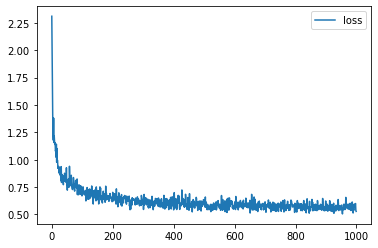

In [16]:
rnncell = RNNCell(
    n_input=len(token_to_id),
    n_hidden=64,
    hidden_activation=tanh,
    hidden_activation_derivative=tanh_derivative,
    bptt_trunc=15
)
rnncell.set_optimizer(ADAM(learning_rate=0.001))

batch_size = 32
history = []
for i in range(1000):
    batch_ix = to_matrix(np.random.choice(names, size=batch_size), token_to_id, max_len=MAX_LENGTH)
    
    encoded_data = np.zeros(shape=(batch_size, MAX_LENGTH, len(token_to_id)))

    for text_i, text in enumerate(encoded_data):
        for letter_i, letter in enumerate(text):
            encoded_data[text_i, letter_i, batch_ix[text_i, letter_i]] = 1
    
    pred = rnncell(encoded_data)

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    rnncell.backward(errors)
    
    # visualizing training process
    history.append(loss / batch_size)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

We have $C$ words in our vocabulary, so each word should be (on average) predicted with probability $1/C$, which would yield a loss of $L = -\frac{1}{N} N \log\frac{1}{C} = \log C$

In [17]:
history[-1]

0.5274381494191192

In [18]:
np.log(len(token_to_id))

3.970291913552122

In [19]:
pred[0, :-1]

array([[-2.63676065,  2.50039585, -1.44706946, ..., -1.48239181,
        -2.55405259, -1.87808507],
       [ 2.27350196, -2.61678972,  1.40036065, ...,  4.95006757,
         0.45848294,  0.03281407],
       [ 0.79930048, -3.39286087,  4.44132459, ...,  2.12714613,
         3.22476402,  2.37378985],
       ...,
       [-2.13598739, -2.43904286, -3.11043029, ..., -1.87505659,
        -3.81978364, -5.12203863],
       [-2.13494202, -2.43669423, -3.11886098, ..., -1.88057382,
        -3.82886004, -5.12978944],
       [-2.13611471, -2.43810651, -3.11800694, ..., -1.88566641,
        -3.82746185, -5.13412428]])

In [20]:
pred[0, :-1].shape

(20, 53)

In [21]:
np.argmax(pred[0, :-1], axis=1, keepdims=True)

array([[35],
       [17],
       [32],
       [17],
       [33],
       [23],
       [34],
       [36],
       [32],
       [ 0],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6]], dtype=int64)

In [22]:
batch_ix[0, 1:].reshape(-1, 1)

array([[14],
       [17],
       [ 2],
       [17],
       [24],
       [23],
       [13],
       [36],
       [32],
       [41],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6],
       [ 6]])

In [23]:
np.argmax(pred[-1, :], axis=1)

array([35, 17, 25, 24, 41, 23, 33,  6, 34,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6], dtype=int64)

In [24]:
for i in np.argmax(pred[-1, :], axis=1):
    print(tokens[i])

A
a
r
h
i
o
n
 
v
 
 
 
 
 
 
 
 
 
 
 
 


In [25]:
for i in batch_ix[-1, :]:
    print(tokens[i])

 
M
o
s
h
k
u
n
o
v
 
 
 
 
 
 
 
 
 
 
 


In [26]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    phrase = copy.copy(seed_phrase)
    
    for t in range(len(seed_phrase)-1, max_length-len(seed_phrase)):
        x_sequence = to_matrix([phrase], token_to_id, max_len=max_length)
        encoded_data = np.zeros(shape=(1, max_length, len(token_to_id)))

        for text_i, text in enumerate(encoded_data):
            for letter_i, letter in enumerate(text):
                encoded_data[text_i, letter_i, x_sequence[text_i, letter_i]] = 1

        pred = char_rnn(encoded_data)
        probs = softmax(pred[:, t] / temperature).ravel()
        next_ix = np.random.choice(len(tokens), p=probs)
        phrase += tokens[next_ix]
    return phrase

In [27]:
for _ in range(10):
    print(generate_sample(rnncell, seed_phrase=' ', temperature=0.4))

 Dovichev            
 Grukhin             
 Marsky              
 Permonov            
 Abaranov            
 Avaev               
 Tovakov             
 Harakhanov          
 Delen               
 Turonov             


![](./images/rnn.png)
![](./images/graph_meanings.png)

In [28]:
class RNNUnit:
    def __init__(
        self,
        n_input,
        n_hidden,
        bptt_trunc=4
    ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.bptt_trunc = bptt_trunc
        
        self.rnn_update = Linear(n_input + n_hidden, n_hidden)
        self.hidden_activation = Activation(tanh, tanh_derivative)
        self.rnn_to_logits = Linear(n_hidden, n_input)
        
        self.x_and_h = None
        self.state_inputs = None
        self.hidden_states = None
        self.outputs = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def set_optimizer(self, optimizer) -> None:
        self.rnn_update.set_optimizer(optimizer)
        self.rnn_to_logits.set_optimizer(optimizer)
        
    def forward(self, x):
        self.input = x
        batch_size, timesteps, input_dim = x.shape
        
        self.x_and_h = np.zeros((batch_size, timesteps, self.n_input+self.n_hidden))
        self.state_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.hidden_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        self.outputs = np.zeros((batch_size, timesteps, self.n_input))

        self.hidden_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        for t in range(timesteps):
            self.x_and_h[:, t] = np.concatenate((x[:, t], self.hidden_states[:, t-1]), axis=1)
            self.state_inputs[:, t] = self.rnn_update(self.x_and_h[:, t])
            self.hidden_states[:, t] = self.hidden_activation(self.state_inputs[:, t])
            self.outputs[:, t] = self.rnn_to_logits(self.hidden_states[:, t])

        return self.outputs
    
    def backward(self, output_error):        
        _, timesteps, _ = output_error.shape

        input_error = np.zeros_like(output_error)
        for t in np.arange(timesteps)[::-1]:
            self.rnn_to_logits.input = self.hidden_states[:, t]
            self.rnn_update.input = self.x_and_h[:, t]
            self.hidden_activation.input = self.state_inputs[:, t]
            
            hidden_error = self.rnn_to_logits.backward(output_error[:, t])
            hidden_error = self.hidden_activation.backward(hidden_error)
            hidden_and_input_error = self.rnn_update.backward(hidden_error)
            
            input_error[:, t] = hidden_and_input_error[:, :self.n_input]
            hidden_error = hidden_and_input_error[:, -self.n_hidden:]
            
            for t_ in np.arange(max(0, t - self.bptt_trunc), t+1)[::-1]:
                self.rnn_update.input = self.x_and_h[:, t_]
                self.hidden_activation.input = self.state_inputs[:, t_]
                
                hidden_error = self.hidden_activation.backward(hidden_error)
                hidden_error = self.rnn_update.backward(hidden_error)[:, -self.n_hidden:]

        return input_error

In [29]:
rnn_unit = RNNUnit(n_input=len(token_to_id),
    n_hidden=64,
    bptt_trunc=15)

rnn_unit.set_optimizer(ADAM())

In [30]:
encoded_data.shape

(32, 21, 53)

In [31]:
rnn_unit.forward(encoded_data).shape

(32, 21, 53)

In [32]:
pred = rnn_unit(encoded_data)

loss = 0
for t in range(batch_ix.shape[1]-1):
    loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])

errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
for t in range(errors.shape[1]-1):
    errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])

rnn_unit.backward(errors)

array([[[-2.74608577e-03, -5.79425457e-03, -2.14790694e-03, ...,
         -1.80334005e-03, -1.12174948e-03, -2.58136456e-03],
        [-1.86948675e-03, -1.33004010e-03,  1.97974102e-03, ...,
         -4.45780070e-03, -3.91690070e-03,  1.27637411e-03],
        [-9.57460481e-03, -1.12698060e-03, -9.81420730e-03, ...,
         -8.67042031e-03, -5.84562927e-03, -2.51545912e-03],
        ...,
        [ 2.26927333e-03, -3.44720904e-03,  1.42750005e-03, ...,
          7.99095866e-04,  2.05859163e-03, -6.70137176e-03],
        [ 2.40075092e-03, -3.13854161e-03,  1.35105651e-03, ...,
          9.34521199e-04,  1.98851005e-03, -6.81246782e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 5.17410499e-03,  4.53441095e-03,  7.16721252e-03, ...,
          4.89188887e-03,  2.57086161e-03,  1.65227604e-03],
        [-2.68645486e-03, -1.84294136e-03,  1.71624561e-03, ...,
         -4.76350799e-03, -3.93753442e

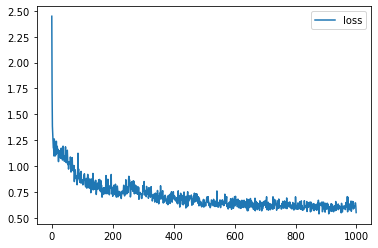

In [33]:
rnnunit = RNNUnit(
    n_input=len(token_to_id),
    n_hidden=64,
    bptt_trunc=20
)
rnnunit.set_optimizer(ADAM(learning_rate=0.0001))

batch_size = 32
history = []
for i in range(1000):
    batch_ix = to_matrix(np.random.choice(names, size=batch_size), token_to_id, max_len=MAX_LENGTH)
    
    encoded_data = np.zeros(shape=(batch_size, MAX_LENGTH, len(token_to_id)))

    for text_i, text in enumerate(encoded_data):
        for letter_i, letter in enumerate(text):
            encoded_data[text_i, letter_i, batch_ix[text_i, letter_i]] = 1
    
    pred = rnnunit(encoded_data)

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    rnnunit.backward(errors)
    
    # visualizing training process
    history.append(loss / batch_size)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [34]:
for _ in range(10):
    print(generate_sample(rnnunit, seed_phrase=' ', temperature=0.4))

 Makhin              
 Abanov              
 Vaderov             
 Linkov              
 Gakhanov            
 Balanov             
 Avdinov             
 Makhan              
 Eadev               
 Tulov               


In [35]:
history[-1]

0.5494931349042641

In [36]:
with open('./style.css') as f:
    style = f.read()
HTML(style)